In [4]:
import csv
import os
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import functions

In [5]:
def get_aqi_data():
    
    '''This function gets all the aqi data from https://aqicn.org for several cities.
    It returns a dictionary with all the dataframes and creates csv files for all of them in
    the current folder'''

    CSV_URLS = 'https://aqicn.org/data-platform/covid19/report/22408-10ad85dd/'
    time_periods = ['2021Q1','2020Q1', '2020Q2', '2020Q3', '2020Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2018H1', '2017H1', '2016H1', 
                '2015H1']

    dic = {}
    for period in time_periods:
        print(period)
    
        response = requests.get(CSV_URLS + period)
        string_data = response.content.decode('utf-8')
        list_data = [row.split(',') for row in string_data.split('\n')]
        # Remove header
        del list_data[:4]
        print(string_data)
    
        columns = list_data[0]
        values = list_data[1:]
    
        dic[period] = pd.DataFrame(values, columns=columns)
        
    for name, df in dic.items():
        df.to_csv('./'+name+'.csv')
    
    return dic



In [6]:
dct = get_aqi_data()

2021Q1
Sorry, this report can not be found


IndexError: list index out of range

In [ ]:
#Save data to csv files
for name, df in dct.items():
    df.to_csv('./'+name+'.csv')

In [ ]:
ls

# Business case

Air pollution is one the main risk factors to develop diseases. The Covid pandemic has given us with an extraordinary situation to study how fast and how much the air pollution would decrease if the...... Has Covid benefitted us in this regard?

# Data cleaning

## Grouping of files and concatenation of DataFrames

In [7]:
def concatenate_per_year(year):
    '''Helper function: Puts together the csv files for a single year in one DataFrame
    INPUT: int year to group
    OUTPUT: pd.DataFrame'''
    files_in_folder = [file for file in os.listdir() if os.path.isfile(os.path.join(os.getcwd(),file))]
                                  
    df = pd.DataFrame()
    for file in files_in_folder:
        if re.search('^{}'.format(str(year)), string=file):
            temp_df = pd.read_csv(file)
            df = pd.concat([df, temp_df])
    return df

def concatenate_all_years(years):
    '''Creates a single dataframe with the data across all years contained in years
    INPUT: list of ints years to concatenate
    OUTPUT: pd.DataFrame with the data for all years'''
    df = pd.DataFrame()
    for year in years:
            df = pd.concat([df, concatenate_per_year(year)])
    return df
        
            

df15 = concatenate_per_year(2015)
df16 = concatenate_per_year(2016)
df17 = concatenate_per_year(2017)
df18 = concatenate_per_year(2018)
df19 = concatenate_per_year(2019)
df20 = concatenate_per_year(2020)
df21 = concatenate_per_year(2021)

In [273]:
df = concatenate_all_years([2015,2016,2017,2018,2019,2020,2021])
df.tail()

,Unnamed: 0,Date,Country,City,Specie,count,min,max,median,variance
529594,NaN,2021-03-24,IL,Petaẖ Tiqwa,wind-gust,4.0,11.3,16.4,15.4,54.57
529595,NaN,2021-01-14,IL,Petaẖ Tiqwa,wind-gust,2.0,13.8,16.4,13.8,33.80
529596,NaN,2021-01-17,IL,Petaẖ Tiqwa,wind-gust,5.0,14.9,16.7,15.4,4.63
529597,NaN,2021-01-19,IL,Petaẖ Tiqwa,wind-gust,4.0,13.8,15.9,14.9,10.02
529598,NaN,2021-01-29,IL,Petaẖ Tiqwa,wind-gust,2.0,10.8,12.8,10.8,20.00


In [274]:
df = df.reset_index().drop(['index', 'Unnamed: 0'], axis=1)

In [275]:
df.shape

(6814872, 9)

Note that in this dataset the value reported for the air quality is the sample median. This magnitude is more statistically sound to report air pollution as it can vary very rapidly and whose distribution can be highly skewed.  We will not be using the "variance", as there is no information about what distribution it refers to (raw data or the distribution of the sample median). For statistical analysis we will be using the natural spread of data. 

In [276]:
df.drop(['variance', 'min', 'max'], axis=1, inplace=True)

Moreover, lets get rid of the data that we are not interested in. This dataframe has information for several markers, which are:

In [277]:
df.Specie.unique()

array(['co', 'pm10', 'o3', 'so2', 'no2', 'pm25', 'psi', 'uvi', 'neph',
       'aqi', 'mepaqi', nan, 'pol', 'temperature', 'humidity', 'pressure',
       'wd', 'wind-speed', 'd', 'pm1', 'wind-gust', 'precipitation',
       'dew', 'wind speed', 'wind gust'], dtype=object)

Although all of the atmospheric parameters in this table can affect the air contamination (specially wind and precipitations), we will be looking at a span of several years, so we will solely focus on the pollutant amount. It is safe to assume the meteorological parameters where approximately the same for the same time periods throughout our 5 year span.

We will study Carbon Monoxide (CO), ozone (o$_3$), sulfur dioxide (SO$_2$), nitrogen dioxide (NO$_2$) and air particle of less than 10 microns (PM$_{10}$) and less than 2.5 microns (PM$_{25}$). Although PM$_1$ is also an important pollutant, it is harder to measure and the amount of data is very small.

In [278]:
pollutants = ['co', 'pm10', 'o3', 'so2', 'no2', 'pm25']
df_whole = df.copy(deep=True)
df = df[df.Specie.isin(pollutants)]

In [279]:
df.Specie.unique(), df.shape

(array(['co', 'pm10', 'o3', 'so2', 'no2', 'pm25'], dtype=object), (3941024, 6))

Now we have all data (almost 4 million points) from 2015-2021 in one DataFrame corresponding to the different air pollutants.

Do we have missing values?:


In [280]:
df.isna().sum()

Date       0
Country    0
City       0
Specie     0
count      0
median     0
dtype: int64

Let's check now what datatypes we have in our table:

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3941024 entries, 0 to 6814705
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Date     object 
 1   Country  object 
 2   City     object 
 3   Specie   object 
 4   count    float64
 5   median   float64
dtypes: float64(2), object(4)
memory usage: 210.5+ MB


Everything looks good except the date, which we want to parse to obtain a datetime type

In [282]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3941024 entries, 0 to 6814705
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   Date     datetime64[ns]
 1   Country  object        
 2   City     object        
 3   Specie   object        
 4   count    float64       
 5   median   float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 210.5+ MB


In [284]:
np.sort(df.Date.dt.year.unique())

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

We have 2014 even though we only downloaded the 2015-2021 time-span

In [285]:
df[df.Date.dt.year == 2014].Date.dt.month.unique()

array([12], dtype=int64)

But we only have the month of December. Since this won't give us any relevant statistical view of 2014 let's drop those rows:

In [286]:
df = df[df.Date.dt.year > 2014]

Although useful for simplicity, the country code renders the data a bit cryptic. Using a dataset from datahub.io let's include the Country name. 

In [287]:
country_name = pd.read_csv('.\country_codes.txt')
country_name

,Name,Code
0,Afghanistan,AF
1,Ã…land Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS
...,...,...
244,Wallis and Futuna,WF
245,Western Sahara,EH
246,Yemen,YE
247,Zambia,ZM


Let's check every country code in our dataset is in the country_name dataframe:

In [288]:
bool_arr = np.array([])
for country in df.Country.unique():
    boolean = country in country_name.Code.unique()
    np.append(bool_arr, boolean)

if bool_arr.all():
    print('All country codes are in country_name')
else: 
    print('There are some country codes not present in country_name')
    

All country codes are in country_name


In [289]:
df = pd.merge(df, country_name, how='inner', left_on='Country', right_on='Code').rename(columns={'Name':'Country_name'}).drop('Code', axis=1)
df.columns.to_list()

['Date', 'Country', 'City', 'Specie', 'count', 'median', 'Country_name']

In [290]:
df = df[['Date', 'Country','Country_name','City','Specie','count','median']]

In [291]:
df = df.rename(columns={'Specie':'Pollutant'})

In [292]:
df.head()

,Date,Country,Country_name,City,Pollutant,count,median
0,2015-01-06,KR,"Korea, Republic of",Jeonju,co,124.0,4.5
1,2015-01-22,KR,"Korea, Republic of",Jeonju,co,116.0,6.7
2,2015-03-30,KR,"Korea, Republic of",Jeonju,co,118.0,5.6
3,2015-05-27,KR,"Korea, Republic of",Jeonju,co,93.0,3.4
4,2015-02-03,KR,"Korea, Republic of",Jeonju,co,133.0,7.8


In [293]:
df_area = pd.read_csv('./country_areas.csv')

In [294]:
df_area = df_area[['Country Name', 'Country Code', 'Indicator Name', '2010']]

In [295]:
df_area

,Country Name,Country Code,Indicator Name,2010
0,Aruba,ABW,Urban land area (sq. km),172.847748
1,Afghanistan,AFG,Urban land area (sq. km),NaN
2,Angola,AGO,Urban land area (sq. km),1427.029541
3,Albania,ALB,Urban land area (sq. km),1689.403809
4,Andorra,AND,Urban land area (sq. km),NaN
...,...,...,...,...
259,Kosovo,XKX,Urban land area (sq. km),NaN
260,"Yemen, Rep.",YEM,Urban land area (sq. km),4703.399902
261,South Africa,ZAF,Urban land area (sq. km),53460.312500
262,Zambia,ZMB,Urban land area (sq. km),NaN


Let's check if all the countries in our air quality dataset is in the areas dataset:

In [296]:
bool_arr = np.array([])
for country in df.Country_name.unique():
    boolean = country in df_area['Country Name'].unique()
    np.append(bool_arr, boolean)

if bool_arr.all():
    print('All country names are in the area dataframe')
else: 
    print('There are some country not present in the areas dataframe')

All country names are in the area dataframe


Let's then do an inner join to include the country areas:


In [300]:
df = pd.merge(df, df_area, how='inner', left_on='Country_name', right_on='Country Name').rename(columns={'2010':'Country_area'})
                                                    


In [304]:
df.columns

Index(['Date', 'Country', 'Country_name', 'City', 'Pollutant', 'count',
       'median', 'Country Name', 'Country Code', 'Indicator Name',
       'Country_area'],
      dtype='object')

In [306]:
df = df.drop(['Country Code', 'Indicator Name'], axis=1)

KeyError: "['Indicator Name', 'Country Code'] not in index"

In [308]:
df = df[['Date', 'Country', 'Country_name', 'Country_area', 'City', 'Pollutant', 'count',
       'median', 'Country Name', 'Country Code', 'Indicator Name']]

In [309]:
df

,Date,Country,Country_name,Country_area,City,Pollutant,count,median,Country Name,Country Code,Indicator Name
0,2015-05-23,NL,Netherlands,12802.993160,Utrecht,so2,8.0,3.1,Netherlands,NLD,Urban land area (sq. km)
1,2015-05-24,NL,Netherlands,12802.993160,Utrecht,so2,20.0,0.6,Netherlands,NLD,Urban land area (sq. km)
2,2015-05-26,NL,Netherlands,12802.993160,Utrecht,so2,16.0,0.6,Netherlands,NLD,Urban land area (sq. km)
3,2015-01-29,NL,Netherlands,12802.993160,Utrecht,so2,4.0,0.6,Netherlands,NLD,Urban land area (sq. km)
4,2015-03-19,NL,Netherlands,12802.993160,Utrecht,so2,2.0,0.6,Netherlands,NLD,Urban land area (sq. km)
...,...,...,...,...,...,...,...,...,...,...,...
3524051,2021-02-05,GH,Ghana,6239.439453,Accra,pm25,24.0,109.0,Ghana,GHA,Urban land area (sq. km)
3524052,2021-02-18,GH,Ghana,6239.439453,Accra,pm25,24.0,74.0,Ghana,GHA,Urban land area (sq. km)
3524053,2021-02-19,GH,Ghana,6239.439453,Accra,pm25,20.0,76.0,Ghana,GHA,Urban land area (sq. km)
3524054,2021-02-26,GH,Ghana,6239.439453,Accra,pm25,24.0,104.0,Ghana,GHA,Urban land area (sq. km)


In [28]:
countries = ['ES', 'IT', 'US', 'IN', 'FR', 'SK', 'DE', 'CN', 'AU']

Let's make a function to calculate the monthly mean AQI values for cities and countries

In [77]:
def monthly_city_pollutant(df):
    print('Calculating the the AQI for each pollutant, month and city')
    final_df = pd.DataFrame()
   
    pollutants = df.Pollutant.unique()
    for pollutant in pollutants:
        pollutant_df = df[df.Pollutant == pollutant]
        countries = pollutant_df.Country.unique()
        for country in countries:
            country_df = pollutant_df[pollutant_df.Country == country]
            cities_country = country_df.City.unique()
            for city in cities_country:
                city_df = country_df[country_df.City == city]
                years = city_df.Date.dt.year.unique()
                for year in years:
                    year_df = city_df[city_df.Date.dt.year == year]
                    months = year_df.Date.dt.month.unique()
                    for month in months:
                        #Dataframe with a particular city in a given country
                        month_df = year_df[year_df.Date.dt.month == month]
                            
                        mean_ser = month_df['median']
                        date_string = '{}/{}'.format(year, month)
                            
                        #Standard deviation
                        std_dev = np.std(month_df['median'])
                        no_days_per_month = month_df.Date.count()
                            
                        std_dev_mean = std_dev/np.sqrt(no_days_per_month)
                            
                        ## T-test confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_days_per_month-1, alpha=alpha)[1] * std_dev_mean
                        # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further
                            
                            
                            
                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'Country_name': month_df.Country_name, 'City': city, 'Pollutant': pollutant, 'No_points': no_days_per_month, \
                                                         'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                        #print(temp_df)
                        final_df = pd.concat([final_df, temp_df])
                        
                        
                           
    return final_df.reset_index().drop('index', axis=1)
    

In [30]:
%%time
month_city_pollut_df = monthly_city_pollutant(df)

Calculating the the AQI for each pollutant, month and city
Wall time: 10min 49s


In [31]:
month_city_pollut_df

,Date,Country,City,Pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2015-01-01,KR,Jeonju,co,29,6.396552,0.262227,0.537148
1,2015-03-01,KR,Jeonju,co,31,5.635484,0.232596,0.475024
2,2015-05-01,KR,Jeonju,co,31,3.719355,0.102763,0.209870
3,2015-02-01,KR,Jeonju,co,28,5.953571,0.266759,0.547344
4,2015-04-01,KR,Jeonju,co,30,4.390000,0.149841,0.306459
...,...,...,...,...,...,...,...,...
147178,2020-12-01,GH,Accra,pm25,35,88.485714,3.538562,7.191224
147179,2020-11-01,GH,Accra,pm25,30,73.366667,1.527149,3.123371
147180,2021-01-01,GH,Accra,pm25,34,101.617647,5.467744,11.124208
147181,2021-02-01,GH,Accra,pm25,28,96.107143,3.164834,6.493702


In [32]:
month_city_pollut_df[(month_city_pollut_df.Country == 'VN') & (month_city_pollut_df.Date.dt.year == 2019) & (month_city_pollut_df.Pollutant == 'pm25') &(month_city_pollut_df.Date.dt.month == 10)]

,Date,Country,City,Pollutant,No_points,AQI,std_dev,conf_interval_95%
135969,2019-10-01,VN,Ho Chi Minh City,pm25,37,87.162162,3.338798,6.771396
136021,2019-10-01,VN,Hanoi,pm25,37,97.729730,5.035397,10.212258
136047,2019-10-01,VN,Hạ Long,pm25,28,53.464286,3.892524,7.986799
136070,2019-10-01,VN,Haiphong,pm25,3,14.666667,0.544331,2.342067


In [78]:
def monthly_country_pollutant(df):
    '''This function calculates the monthly aqi average of all the pollutants present in the table for the inserted countries and for all the available years in the dataset.
    It also corrects the median values which are larger than 500 (following the US EPA standard, which ranges from 0-500)
    INPUT: df: pd.DataFrame with columns 'Date', 'Country', 'City', 'median'
            countries: list with the countries to be extracted
            cities: bool if False the output is a pd.DataFrame with the COUNTRY average AQI values per month. If True, the output is a pd.DataFrame with the CITIES AQI average per month
    OUTPUT: '''
    print('Calculating the the AQI for each pollutant, month and country')
    if 'AQI' in df.columns: #already treated dataframe with city means. See monthly_city_pollutant function
        print('Logical')
        city_df = df
        final_df = pd.DataFrame()
        years = np.sort(city_df.Date.dt.year.unique())
        for year in years:
            year_df = city_df[city_df.Date.dt.year == year]
            months = year_df.Date.dt.month.unique()
            for month in months:
                month_df = year_df[year_df.Date.dt.month == month]
                countries = month_df.Country.unique()
                for country in countries:
                    country_df = month_df[month_df.Country == country]
                    pollutants = country_df.Pollutant.unique()

                    # Calculation of the yearly mean for each pollutant:
                    for pollutant in pollutants:
                        pollutant_df = country_df[country_df.Pollutant == pollutant]

                        # Yearly mean of the AQI for a particular pollutant and country
                        mean_yearly_pollutant = pollutant_df['AQI'].mean() 

                        # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                        std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
                        no_points = pollutant_df.shape[0]

                        total_no_points = pollutant_df.No_points.sum()
                        #T-test confidence interval calculation
                        if no_points == 1: # If the country has only 1 city per month, then use their original intervals and errors
                            error_95th = pollutant_df['conf_interval_95%']
                        else:
                            alpha= 0.95
                            error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean

                        # Calculation of the overall AQI (max of the individual pollutant AQIs)

                        date_string = '{}/{}'.format(year, month)
                        temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'Country_name': pollutant_df.Country_name, 'Total_no_points': total_no_points, \
                                                    'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                        final_df = pd.concat([final_df, temp_df])    
        
        
    else: # raw data. We take each country as a single population, not as a region composed of individual cities.
        #CALL HERE monthly_city_pollutant() WITH AN INPUT() SAYING THAT IT IS BETTER TO USE THE DF RETURNED FROM MONTHLY CITY
        #inp = input('''Beware: inserting the original DataFrame will imply a long runtime process > 10 min. It is advised
        #            to use the returned DataFrame when appliying the function monthly_city_pollutant. Do you want to continue anyway?\n
         #           Press "Y" for Yes
         #           Press "N" for No''')
        
        #if inp == 'Y':
         #   function
        #else:
         #   break
        print('Not_logical')
        print(df.columns)
        final_df = pd.DataFrame()
        pollutants = df.Pollutant.unique()
        for pollutant in pollutants:
            pollutant_df = df[df.Pollutant == pollutant]
            countries = pollutant_df.Country.unique()
            for country in countries:
                country_df = pollutant_df[pollutant_df.Country == country]
                years = country_df.Date.dt.year.unique()
                for year in years:
                    year_df = country_df[country_df.Date.dt.year == year]
                    months = year_df.Date.dt.month.unique()
                    for month in months:
                        #Dataframe with all cities for a given country
                        month_country_df = year_df[year_df.Date.dt.month == month]

                        mean_ser = month_country_df['median'] 
                        date_string = '{}/{}'.format(year, month)

                        #Standard deviation
                        std_dev = np.std(month_country_df['median'])
                        no_points = month_country_df.shape[0]

                        std_dev_mean = std_dev/np.sqrt(no_points)

                        ## T-test confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further

                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'No_points': no_points, 'Pollutant': pollutant, \
                                                         'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})

                        #print(temp_df)
                        final_df = pd.concat([final_df, temp_df])


                

                        
                           
    return final_df.reset_index().drop('index', axis=1)

In [34]:
month_country_pollut_df = monthly_country_pollutant(month_city_pollut_df)

Calculating the the AQI for each pollutant, month and country
Logical


In [35]:
month_country_pollut_df[(month_country_pollut_df.Country == 'VN') & (month_country_pollut_df.Date.dt.year == 2019)]

,Date,Country,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%
9869,2019-03-01,VN,21,1,so2,500.000000,0.000000,0.000000
9870,2019-03-01,VN,60,2,pm25,79.919911,3.325941,42.260091
10207,2019-01-01,VN,6,1,so2,500.000000,0.000000,0.000000
10208,2019-01-01,VN,62,2,pm25,99.145161,4.243624,53.920351
10544,2019-02-01,VN,15,1,so2,500.000000,0.000000,0.000000
10545,2019-02-01,VN,56,2,pm25,80.035714,3.037481,38.594852
10895,2019-04-01,VN,60,2,pm25,69.883333,3.710277,47.143543
11047,2019-06-01,VN,90,3,co,0.395556,0.156216,0.672143
11048,2019-06-01,VN,90,3,pm10,0.811111,0.271446,1.167939
11049,2019-06-01,VN,64,3,o3,3.591667,0.963797,4.146884


Create table with the worldwide average AQI

In [79]:
def monthly_country_AQI(data):
    print('Calculating the overall AQI for each month and country')
    #Initialize the correct Dataframe input
    cou_df = monthly_country_pollutant(data)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            months = country_df.Date.dt.month.unique()
            for month in months:
                month_df = country_df[country_df.Date.dt.month == month]
                
                max_idx = month_df['AQI'].idxmax()
                overall_monthly_AQI = month_df.loc[max_idx, 'AQI']
                most_present_pollutant = month_df.loc[max_idx, 'Pollutant']
                std_dev_monthly_AQI = month_df.loc[max_idx, 'std_dev']
                conf_interval_monthly_AQI = month_df.loc[max_idx, 'conf_interval_95%']
                total_no_points = month_df.No_points.sum()
                no_points = month_df.loc[max_idx, 'No_points']
                
                
                
                date_string = '{}/{}'.format(year, month)
                temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'Country_name': month_df.Country_name, 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [overall_monthly_AQI], 'std_dev': std_dev_monthly_AQI, 'conf_interval_95%': conf_interval_monthly_AQI})
                final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)
    

In [37]:
month_country_AQI_df = monthly_country_AQI(month_city_pollut_df)

Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Logical


In [38]:
month_country_AQI_df[month_country_AQI_df.Country == 'GH']

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
3939,2020-03-01,GH,1,pm25,1,59.200000,2.536139,7.041450
3940,2020-04-01,GH,1,pm25,1,61.857143,1.286122,2.613715
3941,2020-05-01,GH,1,pm25,1,56.322581,1.451532,2.964424
3942,2020-06-01,GH,1,pm25,1,61.656250,1.566002,3.193882
3943,2020-07-01,GH,1,pm25,1,69.472222,1.423180,2.889209
3944,2020-08-01,GH,1,pm25,1,67.096774,1.079903,2.205457
3945,2020-09-01,GH,1,pm25,1,55.787879,1.053881,2.146686
3946,2020-10-01,GH,1,pm25,1,54.485714,1.292598,2.626876
3947,2020-11-01,GH,1,pm25,1,73.366667,1.527149,3.123371
3948,2020-12-01,GH,1,pm25,1,88.485714,3.538562,7.191224


In [40]:
month_country_AQI_df[month_country_AQI_df.Country == 'GH']

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
3939,2020-03-01,GH,1,pm25,1,59.200000,2.536139,7.041450
3940,2020-04-01,GH,1,pm25,1,61.857143,1.286122,2.613715
3941,2020-05-01,GH,1,pm25,1,56.322581,1.451532,2.964424
3942,2020-06-01,GH,1,pm25,1,61.656250,1.566002,3.193882
3943,2020-07-01,GH,1,pm25,1,69.472222,1.423180,2.889209
3944,2020-08-01,GH,1,pm25,1,67.096774,1.079903,2.205457
3945,2020-09-01,GH,1,pm25,1,55.787879,1.053881,2.146686
3946,2020-10-01,GH,1,pm25,1,54.485714,1.292598,2.626876
3947,2020-11-01,GH,1,pm25,1,73.366667,1.527149,3.123371
3948,2020-12-01,GH,1,pm25,1,88.485714,3.538562,7.191224


In [80]:
def yearly_country_AQI(data):
    '''The input for this function must be a dataframe with output from calculate_pollutant_country(cities=False)'''
    
    print('Calculating the overall AQI for each year and country')
    cou_df = monthly_country_AQI(data)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
           
                
            # Yearly mean of the AQI for a particular pollutant and country
            mean_yearly_AQI = country_df['AQI'].mean() 
                
            # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
            std_dev_mean = np.sqrt((country_df.std_dev ** 2).sum())/country_df.shape[0] # Propagation of std. deviations for the mean
            no_points = country_df.shape[0]
                
            total_no_points = country_df.Total_no_points.sum()
            
            #T-test confidence interval calculation
            if no_points == 1: # If the country has only 1 month per year, then use that month's confidence interval
                error_95th = country_df['conf_interval_95%']
            else:
                alpha= 0.95
                error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
            
            most_present_pollutant = country_df['Most_present_pollutant'].value_counts().index[0]
            
                
              
            date_string = '{}'.format(year)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Country_name': country_df.Country_name, 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [mean_yearly_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
            final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)

In [42]:
%%time
year_country_AQI_df = yearly_country_AQI(month_city_pollut_df)

Calculating the overall AQI for each year and country
Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Logical
Wall time: 1min 9s


In [43]:
year_country_AQI_df

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2015-01-01,KR,936,pm25,8,81.234247,0.713103,1.686220
1,2015-01-01,NL,424,pm25,8,48.394428,0.559931,1.324025
2,2015-01-01,IL,284,pm25,8,69.992343,2.127219,5.030074
3,2015-01-01,BE,271,pm25,8,49.134778,0.759516,1.795969
4,2015-01-01,LT,40,pm25,8,46.050579,1.798914,4.253756
...,...,...,...,...,...,...,...,...
529,2021-01-01,GN,3,pm25,3,117.881204,6.091721,26.210560
530,2021-01-01,CI,3,pm25,3,100.969444,2.186901,9.409475
531,2021-01-01,GH,3,pm25,3,92.974930,2.277981,9.801363
532,2021-01-01,CZ,50,pm25,2,73.685000,4.649397,59.076184


In [81]:
def yearly_country_pollutant(data):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    
    print('Calculating the AQI for each pollutant, year and country')
    cou_df = monthly_country_pollutant(data)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            pollutants = country_df.Pollutant.unique()
            
            # Calculation of the yearly mean for each pollutant:
            for pollutant in pollutants:
                pollutant_df = country_df[country_df.Pollutant == pollutant]
                
                # Yearly mean of the AQI for a particular pollutant and country
                mean_yearly_pollutant = pollutant_df['AQI'].mean() 
                
                # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
                no_points = pollutant_df.shape[0]
                
                total_no_points = pollutant_df.No_points.sum()
                #T-test confidence interval calculation
                alpha= 0.95
                error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                
                # Calculation of the overall AQI (max of the individual pollutant AQIs)
                
                date_string = '{}'.format(year)
                temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Country_name': pollutant_df.Country_name, 'Total_no_points': total_no_points, \
                                            'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)

In [45]:
%%time
year_country_pollut_df = yearly_country_pollutant(month_city_pollut_df)

Calculating the AQI for each pollutant, year and country
Calculating the the AQI for each pollutant, month and country
Logical
Wall time: 1min 1s


In [46]:
year_country_pollut_df

,Date,Country,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%
0,2015-01-01,KR,160,8,co,5.966860,0.033426,0.079040
1,2015-01-01,KR,160,8,pm10,42.081079,0.340491,0.805132
2,2015-01-01,KR,160,8,o3,22.855549,0.120579,0.285125
3,2015-01-01,KR,160,8,so2,7.069691,0.031848,0.075308
4,2015-01-01,KR,160,8,no2,18.701611,0.133128,0.314798
...,...,...,...,...,...,...,...,...
2501,2021-01-01,CZ,10,2,o3,15.077800,0.820572,10.426361
2502,2021-01-01,CZ,10,2,so2,2.059600,0.071785,0.912114
2503,2021-01-01,CZ,10,2,no2,10.057800,0.696328,8.847682
2504,2021-01-01,CZ,10,2,pm25,73.685000,4.649397,59.076184


In [47]:
def yearly_world_AQI(data):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    
    print('Calculating the mean overall worldwide AQI for each year')
    yearly_cou_df = yearly_country_AQI(data)
    
    final_df = pd.DataFrame()
    years = np.sort(yearly_cou_df.Date.dt.year.unique())
    for year in years:
        year_df = yearly_cou_df[yearly_cou_df.Date.dt.year == year]
        
        # World mean AQI:
        mean_world_AQI = year_df.AQI.mean()
        
        # Standard deviation:
        std_dev_mean = np.sqrt((year_df.std_dev ** 2).sum())/year_df.shape[0] # Propagation of standard deviation for the mean
        no_points = year_df.shape[0]
        
        total_no_points = year_df.Total_no_points.sum()
        
        # T-test confidence interval
        alpha= 0.95
        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
        
        
        date_string = '{}'.format(year)
        temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Total_no_points': total_no_points, 'Most_present_pollutant': year_df.Most_present_pollutant.value_counts().index[0], \
                                'No_points': no_points, 'AQI': [mean_world_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
        final_df = pd.concat([final_df, temp_df])
    
    return final_df.reset_index().drop('index', axis=1)

In [48]:
df.Pollutant.value_counts().index[0]

'no2'

In [49]:
'AQI' in month_city_pollut_df

True

In [50]:
%%time
yearly_world = yearly_world_AQI(month_city_pollut_df)

Calculating the mean overall worldwide AQI for each year
Calculating the overall AQI for each year and country
Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Logical
Wall time: 1min 8s


In [51]:
yearly_world

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2015-01-01,17339,pm25,59,58.412738,0.307093,0.614714
1,2016-01-01,18307,pm25,63,61.571195,0.489108,0.977712
2,2017-01-01,16190,pm25,64,62.823182,0.199474,0.398617
3,2018-01-01,19853,pm25,73,62.863041,0.119284,0.237788
4,2019-01-01,32856,pm25,90,64.465806,0.264139,0.524839
5,2020-01-01,34133,pm25,93,57.849609,0.104615,0.207775
6,2021-01-01,8505,pm25,92,71.442336,0.307963,0.611730


In [53]:
yearly_world ## measured with city averages

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2015-01-01,17339,pm25,59,58.412738,0.307093,0.614714
1,2016-01-01,18307,pm25,63,61.571195,0.489108,0.977712
2,2017-01-01,16190,pm25,64,62.823182,0.199474,0.398617
3,2018-01-01,19853,pm25,73,62.863041,0.119284,0.237788
4,2019-01-01,32856,pm25,90,64.465806,0.264139,0.524839
5,2020-01-01,34133,pm25,93,57.849609,0.104615,0.207775
6,2021-01-01,8505,pm25,92,71.442336,0.307963,0.611730


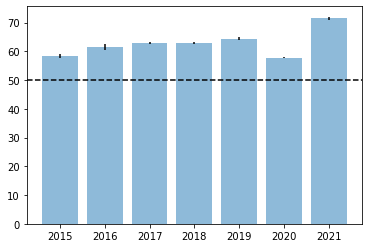

In [54]:
plt.bar(yearly_world[yearly_world.Date.dt.year > 2014].Date.dt.year, yearly_world[yearly_world.Date.dt.year > 2014].AQI, \
        alpha=0.5, yerr= yearly_world[yearly_world.Date.dt.year > 2014]['conf_interval_95%'])
plt.axhline(y=50, color='black', linestyle='--' )

The overall mean AQI in the world steadily rised from 2015. However, we can see a drop in 2020. Comparing the year 2019 to 2020 by a Welch t-test (assuming unequal variances):



In [56]:
mean_2019, std_2019 = yearly_world[yearly_world.Date.dt.year == 2019]['AQI'].values[0], yearly_world[yearly_world.Date.dt.year == 2019]['std_dev'].values[0]
mean_2020, std_2020 = yearly_world[yearly_world.Date.dt.year == 2020]['AQI'].values[0], yearly_world[yearly_world.Date.dt.year == 2020]['std_dev'].values[0]

statistic = mean_2019-mean_2020
n_2019 = yearly_world[yearly_world.Date.dt.year == 2019]['No_points'].values[0]
n_2020 = yearly_world[yearly_world.Date.dt.year == 2020]['No_points'].values[0]

std_statistic = np.sqrt(std_2019**2 + std_2020**2)
df_welch = (std_2019**2+std_2020**2)**2/(std_2019**2/(n_2019-1) + std_2020**2/(n_2020-1))




alpha= 0.95
error = stats.t.interval(df=df_welch, alpha=alpha)[1] * std_statistic
CI = np.array([statistic-error, statistic+error])
CI_percent = (CI/mean_2019)*100
CI_percent

array([ 9.22729063, 11.29892945])

There is a drop in the world AQI between 9 and 11%, within a 95% confidence interval. How is the monthly decrease?

In [57]:
def monthly_world_AQI(data):
    
    print('Calculating the worldwide overall mean AQI for each month')
    cou_df = monthly_country_AQI(data)
    
    '''fdh'''
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        months = year_df.Date.dt.month.unique()
        for month in months:
            month_df = year_df[year_df.Date.dt.month == month]
           
                
            # Monthly mean of the AQI across all countries
            mean_monthly_AQI = month_df['AQI'].mean() 
                
            # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
            std_dev_mean = np.sqrt((month_df.std_dev ** 2).sum())/month_df.shape[0] # Propagation of std. deviations for the mean
            no_points = month_df.shape[0]
                
            total_no_points = month_df.Total_no_points.sum()
            
            #T-test confidence interval calculation
            alpha= 0.95
            error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
            
            most_present_pollutant = month_df['Most_present_pollutant'].value_counts().index[0]
            
                
              
            date_string = '{}/{}'.format(year, month)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [mean_monthly_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
            final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)
    

In [58]:
%%time
month_world_AQI_df = monthly_world_AQI(month_city_pollut_df)

Calculating the worldwide overall mean AQI for each month
Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Logical
Wall time: 1min 7s


In [171]:
month_world_AQI_df.sort_values(by='Date', inplace=True)
month_world_AQI_df

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2015-01-01,2097,pm25,48,65.624371,0.532468,1.071187
3,2015-02-01,2112,pm25,49,66.990701,0.485621,0.976406
1,2015-03-01,2119,pm25,49,62.595113,0.427851,0.860251
4,2015-04-01,2207,pm25,55,54.966281,0.441381,0.884916
2,2015-05-01,2242,pm25,56,53.128205,0.340730,0.682839
5,2015-06-01,2234,pm25,56,51.215444,0.319376,0.640043
6,2015-07-01,2149,pm25,56,54.707256,0.406027,0.813696
7,2015-12-01,2179,pm25,53,68.128263,1.459687,2.929077
12,2016-01-01,2288,pm25,58,65.867377,0.476581,0.954338
8,2016-02-01,2272,pm25,58,56.698683,0.479383,0.959947


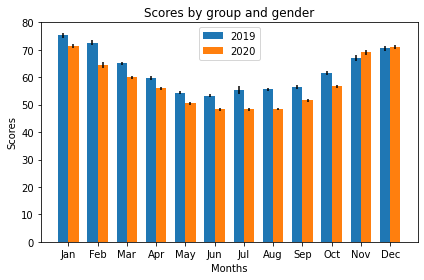

In [172]:
year_19 =  month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2019)].AQI
year_20 =  month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2020)].AQI

err_19 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2019)]['conf_interval_95%']
err_20 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2020)]['conf_interval_95%']

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, year_19, width, label='2019', yerr= err_19)
rects2 = ax.bar(x + width/2, year_20, width, label='2020', yerr= err_20)


ax.set_ylabel('Scores')
ax.set_xlabel('Months')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [162]:
def t_conf_interval(df_a, df_b, percent=True, confidence_interval=0.95):
    '''This function calculates a confidence interval via a t-statistic between months of 2 different years. If the ratio between variances is larger than 2, then a 
    Welch t-test is performed. The statistic is taken as (df_a) - (df_b)
    INPUT: Dataframe with the mean values of the distributions we want to compare and the std_dev of those means'''
    final_df = pd.DataFrame()
    years = df_a.Date.dt.year.unique()
    for year in years:
        months = months = list(set(df_a.Date.dt.month.unique()).intersection(set(df_b.Date.dt.month.unique())))
        for month in months:
            mean_a = df_a[df_a.Date.dt.month == month].AQI.values[0]
            print(mean_a)
            mean_b = df_b[df_b.Date.dt.month == month].AQI.values[0]
            print(mean_b)

            std_a = df_a[df_a.Date.dt.month == month].std_dev.values[0]
            std_b = df_b[df_b.Date.dt.month == month].std_dev.values[0]

            statistic = mean_a-mean_b

            n_a = df_a[df_a.Date.dt.month == month]['No_points'].values[0]
            n_b = df_b[df_b.Date.dt.month == month]['No_points'].values[0]

            std_statistic = np.sqrt(std_a**2 + std_b**2)
            if (std_a**2/std_b**2 > 2) or (std_a**2/std_b**2) < 0.5:
                #Apply Welch t-test method
                degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))
            
            degrees_freedom = n_a + n_b - 2

            alpha= 0.95
            #Calculate percentage with respect to the previous year
            if percent:
                ratio = statistic/mean_b
                std_dev_mean_b = df_b[df_b.Date.dt.month == month].std_dev.values[0]
                std_dev_ratio = ratio * np.sqrt((std_statistic / statistic)**2 + (std_dev_mean_b  / mean_b)**2) # Propagation by Taylor approximation to first degree
                
                percent = ratio *100
                std_percent = std_dev_ratio*100
                
                CI = [percent, std_percent]
            if not percent:
                error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
                CI = np.array([statistic, error])
            temp_df = pd.DataFrame({'Years_compared':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Month': month, \
                                    'middle': CI[0], 'std_95th': [CI[1]]})
            final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1).sort_values(by='Month')

In [223]:
df_month_2018 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2018)]

In [224]:
df_month_2018

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
24,2018-01-01,2428,pm25,67,71.642298,0.497157,0.992606
28,2018-02-01,2483,pm25,68,72.099210,0.415707,0.829755
25,2018-03-01,2491,pm25,68,67.461547,0.359404,0.717373
26,2018-04-01,2478,pm25,68,59.740708,0.341118,0.680875
27,2018-05-01,2494,pm25,68,59.277324,0.271149,0.541216
23,2018-06-01,2553,pm25,70,55.963747,0.526311,1.049962
29,2018-07-01,2414,pm25,69,52.970280,0.000000,0.000000
30,2018-12-01,2512,pm25,72,62.738023,0.000000,0.000000


In [225]:
df_month_2019

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
32,2019-01-01,2609,pm25,72,75.317178,0.441024,0.879376
33,2019-02-01,2613,pm25,75,72.621678,0.444561,0.885808
31,2019-03-01,2704,pm25,79,65.052029,0.300558,0.598365
34,2019-04-01,2694,pm25,80,59.846943,0.394860,0.785950
36,2019-05-01,2734,pm25,81,54.407909,0.307451,0.611846
35,2019-06-01,2765,pm25,83,53.197144,0.269424,0.535971
39,2019-07-01,2775,pm25,82,55.353920,0.707495,1.407692
37,2019-08-01,2773,pm25,83,55.584557,0.286157,0.569258
38,2019-09-01,2766,pm25,83,56.453814,0.385238,0.766361
40,2019-10-01,2769,pm25,83,61.401740,0.369122,0.734302


In [185]:
df_month_2019 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2019)]
df_month_2020 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2020)]

# Confidence intervals for all months of 2019-2020 years:

df_conf = t_conf_interval(df_month_2020, df_month_2019, percent=True)

71.3848529038706
75.31717767784646
64.53052187099162
72.62167767412589
59.99509856772615
65.05202925478147
55.95440917143485
59.84694291977494
50.43494927249454
54.40790857594658
48.30363690036569
53.197143737301445
48.25259342741937
55.353919930958654
48.409280657848385
55.58455730756241
51.632262449398546
56.453813529466075
56.69107081271319
61.40173973425505
69.07509886942152
67.07185369930743
70.8970900774512
70.56622361201309


In [186]:
df_conf

,Years_compared,Month,middle,std_95th
0,2020-2019,1,-5.221020,-0.808774
1,2020-2019,2,-11.141516,-0.944742
2,2020-2019,3,-7.773671,-0.678896
3,2020-2019,4,-6.504148,-0.826577
4,2020-2019,5,-7.302172,-0.786764
5,2020-2019,6,-9.198815,-0.669655
6,2020-2019,7,-12.828950,-1.346063
7,2020-2019,8,-12.908759,-0.673938
8,2020-2019,9,-8.540700,-0.803394
9,2020-2019,10,-7.671882,-0.757866


In [212]:
def plot_with_err(x, data, **kwargs):
    y = data.middle
    lines = plt.plot(x, y, '-', **kwargs)
    middle = data.middle
    std = data.std_95th
    plt.fill_between(x, middle - std, middle + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


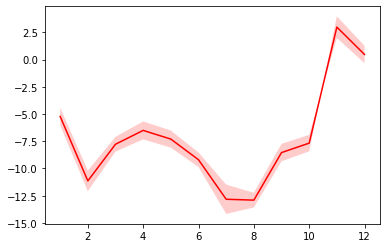

In [213]:
plot_with_err(df_conf.Month, df_conf, color='r')

In [66]:
def yearly_world_pollutant(df):
    
    cou_df = yearly_country_polreset_indext(df)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        pollutants = year_df.Pollutant.unique()
            
        # Calculation of the yearly mean for each pollutant:
        for pollutant in pollutants:
            pollutant_df = year_df[year_df.Pollutant == pollutant]
                
            # Yearly mean of the AQI for a particular pollutant and country
            mean_yearly_pollutant = pollutant_df['AQI'].mean() 
                
            # Standard deviation of the worldwide mean yearly pollutant. Assuming i.i.d i.e Cov = 0
            std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
            no_points = pollutant_df.shape[0]
                
            total_no_points = pollutant_df.No_points.sum()
            #T-test confidence interval calculation
            alpha= 0.95
            error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                
            date_string = '{}'.format(year)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Total_no_points': total_no_points, \
                                            'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
            final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)
    

In [67]:
%%time
year_world_pollut_df = yearly_world_pollutant(month_city_pollut_df)

Calculating the AQI for each pollutant, year and country
Calculating the the AQI for each pollutant, month and country
Logical
Wall time: 1min 2s


In [68]:
year_world_pollut_df[year_world_pollut_df.Pollutant == 'pm1']

,Date,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%


In [83]:
year_world_pollut_df

,Date,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%
0,2015-01-01,349,49,co,5.164896,0.053051,0.106667
1,2015-01-01,406,58,pm10,30.543595,0.179042,0.358525
2,2015-01-01,380,50,o3,20.173801,0.062827,0.126255
3,2015-01-01,391,52,so2,5.772196,0.043056,0.086439
4,2015-01-01,394,54,no2,13.576777,0.041820,0.083880
5,2015-01-01,374,54,pm25,59.899327,0.334722,0.671367
6,2016-01-01,368,49,co,5.595470,0.058035,0.116687
7,2016-01-01,446,59,pm10,30.672143,0.526944,1.054793
8,2016-01-01,406,53,o3,19.746596,0.057683,0.115749
9,2016-01-01,416,55,so2,4.383822,0.063948,0.128208


Let's calculate the relative amounts of each pollutant each year

In [150]:
ratio_df = pd.DataFrame()
for year in year_world_pollut_df.Date.dt.year.unique():
    year_df = year_world_pollut_df[year_world_pollut_df.Date.dt.year == year]
    
    sum_AQI_year = year_df.AQI.sum()
    std_dev_sum = np.sqrt(np.sum(year_df['std_dev'] ** 2)) # Propagation
    
    for pollutant in year_df.Pollutant.unique():
        pollutant_df = year_df[year_df.Pollutant == pollutant]
        
        ratio = 100*((pollutant_df.AQI / sum_AQI_year)).values[0] #ratio of each pollutant with respect to the sum of all the AQIs of all pollutants
        std_dev_ratio = ratio * np.sqrt((pollutant_df.std_dev / pollutant_df.AQI)**2 + (std_dev_sum  / sum_AQI_year)**2) # Propagation by Taylor approximation to first degree
        no_points = pollutant_df.No_points
        
        #T-test confidence interval calculation
        alpha= 0.95
        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_ratio
        
        date_string = '{}'.format(year)
        temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Pollutant': pollutant, 'rel_AQI': [ratio], 'std_dev': std_dev_ratio, 'conf_interval_95%': error_95th})
        
        ratio_df = pd.concat([ratio_df, temp_df])
    

In [151]:
ratio_df

,Date,Pollutant,rel_AQI,std_dev,conf_interval_95%
0,2015-01-01,co,3.822151,0.040803,0.082039
1,2015-01-01,pm10,22.603020,0.147907,0.296179
2,2015-01-01,o3,14.929115,0.063615,0.127839
3,2015-01-01,so2,4.271568,0.034199,0.068657
4,2015-01-01,no2,10.047153,0.042563,0.085371
5,2015-01-01,pm25,44.326993,0.279244,0.560092
6,2016-01-01,co,4.116549,0.048446,0.097407
7,2016-01-01,pm10,22.565286,0.407474,0.815647
8,2016-01-01,o3,14.527436,0.091257,0.183120
9,2016-01-01,so2,3.225148,0.050349,0.100944


<AxesSubplot:xlabel='Date', ylabel='rel_AQI'>

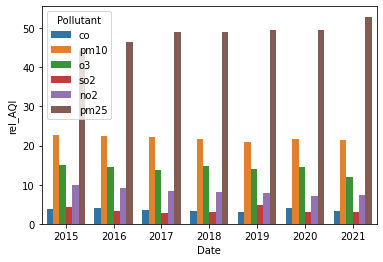

In [152]:
# Relative amounts of each pollutant

years = ratio_df.Date.dt.year
year_world_pollut = ratio_df.rel_AQI
hue = ratio_df.Pollutant

sns.barplot(x=years, y=year_world_pollut, \
        alpha=1, hue=hue)

<AxesSubplot:xlabel='Date', ylabel='AQI'>

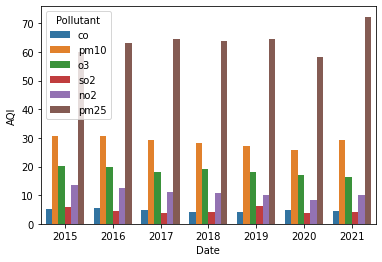

In [70]:
#Absolute amounts of each pollutant

years = year_world_pollut_df.Date.dt.year
year_world_pollut = year_world_pollut_df.AQI
hue = year_world_pollut_df.Pollutant

sns.barplot(x=years, y=year_world_pollut, \
        alpha=1, hue=hue)

In [217]:
df_pollut_19 = year_world_pollut_df[year_world_pollut_df.Date.dt.year == 2019].sort_values(by='Pollutant')
df_pollut_20 = year_world_pollut_df[year_world_pollut_df.Date.dt.year == 2020].sort_values(by='Pollutant')

In [218]:
df_pollut_19

,Date,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%
24,2019-01-01,604,54,co,4.006056,0.039128,0.078482
28,2019-01-01,693,61,no2,10.231731,0.119043,0.238122
26,2019-01-01,677,61,o3,18.200639,0.122904,0.245846
25,2019-01-01,762,68,pm10,27.247401,0.218018,0.435165
29,2019-01-01,932,87,pm25,64.511535,0.275916,0.548503
27,2019-01-01,693,61,so2,6.206889,0.115817,0.231668


In [222]:
100*(df_pollut_20.AQI.reset_index() - df_pollut_19.AQI.reset_index())/df_pollut_19.AQI.sum()

,index,AQI
0,4.601077,0.537500
1,4.601077,-1.414579
2,4.601077,-0.834950
3,4.601077,-1.187344
4,4.601077,-4.676547
5,4.601077,-1.953532


# DECREASE BY COUNTRY


Let's modifiy the previous t_conf_interval() function to take Dataframes with the "Country" column:

In [71]:
def t_conf_interval_country(df_a, df_b, percent=True, confidence_interval=0.95):
    '''This function calculates a confidence interval via a t-statistic. If the ratio between variances is larger than 2, then a 
    Welch t-test is performed. The statistic is taken as (df_a) - (df_b)
    INPUT: Dataframes with the mean values of the distributions we want to compare and the std_dev of those means
           percent: if False only difference between means is computed. If True, a percentage is calculated relative to df_b'''
    final_df = pd.DataFrame()
    
    countries = list(set(df_a.Country.unique()).intersection(set(df_b.Country.unique())))
    for country in countries:
        country_filter_a = df_a.Country == country
        country_filter_b = df_b.Country == country
        months = list(set(df_a.Date.dt.month.unique()).intersection(set(df_b.Date.dt.month.unique())))
        for month in months:
            month_filter_a = df_a.Date.dt.month == month
            month_filter_b = df_b.Date.dt.month == month
                
            mean_a = df_a[month_filter_a & country_filter_a].AQI.values[0]
            mean_b = df_b[month_filter_b & country_filter_b].AQI.values[0]

            std_a = df_a[month_filter_a & country_filter_a].std_dev.values[0]
            std_b = df_b[month_filter_b & country_filter_b].std_dev.values[0]

            statistic = mean_a-mean_b

            n_a = df_a[month_filter_a & country_filter_a]['No_points'].values[0]
            n_b = df_b[month_filter_b & country_filter_b]['No_points'].values[0]

            std_statistic = np.sqrt(std_2019**2 + std_2020**2)
            if (std_a**2/std_b**2 > 2) or (std_a**2/std_b**2) < 0.5:
                #Apply Welch t-test method
                degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))

            degrees_freedom = n_a + n_b - 2

            alpha= 0.95
            error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
            CI = np.array([statistic, error])
            #Calculate percentage with respect to the previous year
            if percent:
                CI = (CI/mean_b)*100
            temp_df = pd.DataFrame({'Year':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Month': month, 'Country': country, \
                                        'difference(%)': CI[0], 'std_95th(%)': [CI[1]]})
            final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1).sort_values(by='Month')

In [72]:
df_19 = year_country_AQI_df[year_country_AQI_df.Date.dt.year == 2019]
df_20 = year_country_AQI_df[year_country_AQI_df.Date.dt.year == 2020]

comp_year_cou_df = t_conf_interval_country(df_20, df_19)

<ipython-input-71-5bd96e9ccc6e>:31: RuntimeWarning: divide by zero encountered in double_scalars
  degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))
<ipython-input-71-5bd96e9ccc6e>:31: RuntimeWarning: divide by zero encountered in double_scalars
  degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))
<ipython-input-71-5bd96e9ccc6e>:31: RuntimeWarning: divide by zero encountered in double_scalars
  degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))
<ipython-input-71-5bd96e9ccc6e>:31: RuntimeWarning: divide by zero encountered in double_scalars
  degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))


In [73]:
comp_year_cou_df.sort_values(by='difference(%)').head(15)

,Year,Month,Country,difference(%),std_95th(%)
54,2020-2019,1,VN,-72.687644,0.357134
44,2020-2019,1,BG,-62.905103,0.841049
84,2020-2019,1,AF,-40.696319,0.330008
57,2020-2019,1,GR,-38.608529,0.785246
51,2020-2019,1,PH,-36.856381,1.177195
48,2020-2019,1,RE,-31.971220,1.704925
12,2020-2019,1,IE,-28.430092,1.615125
40,2020-2019,1,KG,-28.429288,0.690801
43,2020-2019,1,GE,-26.158807,0.619822
72,2020-2019,1,BR,-25.643834,1.247753


In [74]:
month_country_AQI_df[(month_country_AQI_df.Country == 'VN') & (month_country_AQI_df.Date.dt.year == 2019)]

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
2626,2019-03-01,VN,3,so2,1,500.000000,0.000000,0.000000
2627,2019-01-01,VN,3,so2,1,500.000000,0.000000,0.000000
2628,2019-02-01,VN,3,so2,1,500.000000,0.000000,0.000000
2629,2019-04-01,VN,2,pm25,2,69.883333,3.710277,47.143543
2630,2019-06-01,VN,19,pm25,4,18.408333,1.031183,3.281685
2631,2019-05-01,VN,19,pm25,4,17.477273,0.573815,1.826136
2632,2019-08-01,VN,18,pm25,4,31.651210,2.278322,7.250637
2633,2019-09-01,VN,18,pm25,4,55.913306,2.359770,7.509841
2634,2019-07-01,VN,18,pm25,4,27.226216,0.443474,1.411333
2635,2019-10-01,VN,18,pm25,4,63.255711,1.801923,5.734524


Some of the values have std_dev = 0, which means that their initial recorded values during the month were exactly 500. This is unlikely, specially for so2 in a place like Ha Long, which is a World Heritage Site. Let's remove those measurements with zero std_dev to obtain statistically relevant data:

In [75]:
month_country_AQI_df[(month_country_AQI_df.std_dev > 0) & (month_country_AQI_df['conf_interval_95%'] < month_country_AQI_df.AQI )].sort_values(by='AQI', ascending=False).head(10)

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
4159,2021-01-01,BD,1,pm25,1,253.176471,6.494537,13.213236
562,2016-01-01,CO,10,o3,2,252.485185,0.178275,2.265199
1820,2018-01-01,BD,1,pm25,1,252.000000,7.508838,15.406864
560,2016-04-01,CO,10,o3,2,251.396667,0.131676,1.673100
561,2016-05-01,CO,10,o3,2,250.853571,0.059597,0.757256
1291,2017-01-01,BD,1,pm25,1,242.333333,8.650541,17.692342
2651,2019-01-01,BD,1,pm25,1,235.548387,6.450619,13.173922
2850,2019-12-01,AF,1,pm25,1,233.562500,12.901742,26.313277
3689,2020-12-01,BD,1,pm25,1,232.057143,5.322105,10.815819
4160,2021-02-01,BD,1,pm25,1,231.750000,8.680206,17.810312


In [76]:
df[(df.Country == 'VN') & (df.Date.dt.year == 2019) & (df.Date.dt.month == 1)]

,Date,Country,Country_name,City,Pollutant,count,median
2340794,2019-01-02,VN,Viet Nam,Ho Chi Minh City,pm25,24.0,82.0
2340795,2019-01-03,VN,Viet Nam,Ho Chi Minh City,pm25,15.0,78.0
2340796,2019-01-16,VN,Viet Nam,Ho Chi Minh City,pm25,24.0,85.0
2340797,2019-01-18,VN,Viet Nam,Ho Chi Minh City,pm25,24.0,76.0
2340802,2019-01-14,VN,Viet Nam,Ho Chi Minh City,pm25,24.0,89.0
...,...,...,...,...,...,...,...
2340990,2019-01-26,VN,Viet Nam,Hạ Long,so2,14.0,500.0
2340996,2019-01-30,VN,Viet Nam,Hạ Long,so2,6.0,500.0
2341002,2019-01-31,VN,Viet Nam,Hạ Long,so2,13.0,500.0
2341008,2019-01-27,VN,Viet Nam,Hạ Long,so2,9.0,500.0
